# カテゴリ値を含むデータでのLightGBMを使った分析

### データ
[Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) \
[Adult Census Income](https://www.kaggle.com/datasets/uciml/adult-census-income) \
[Adult income dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset)

### 参考
[lightgbmで二値分類の一連の流れをしたメモ](https://qiita.com/d_desuyon/items/807e01311ad08570ee78) \
[【初心者向け】特徴量重要度の算出 (LightGBM) 【Python】【機械学習】](https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/) \
[LightGBMのCategorical Featureによって精度が向上するか？](https://qiita.com/sinchir0/items/b038757e578b790ec96a) \
[Pythonでしか描けない美しいデシジョンツリー（決定木）をlightGBMでも描こう！](https://qiita.com/hima2b4/items/b356e688ebdabc393da8) \
[LightGBM/XGBoostのtree構造可視化メモ](https://qiita.com/dyamaguc/items/70d4ce3548d49a6256fa) \
[Category Encodersでカテゴリ特徴量をストレスなく変換する](https://qiita.com/Hyperion13fleet/items/afa49a84bd5db65ffc31) \
[カテゴリ変数系特徴量の前処理(scikit-learnとcategory_encoders)](https://qiita.com/FukuharaYohei/items/06cc7b1c5eb124db6cdf) \
[LightGBMのCategorical Featureによって精度が向上するか？](https://qiita.com/sinchir0/items/b038757e578b790ec96a) \
[LightGBMでOptunaを使用するときの再現性確保について](https://book-read-yoshi.hatenablog.com/entry/2021/03/22/lightgbm_optuna_deterministic)

In [1]:
!python -V

Python 3.9.13


In [2]:
!python -m pip --version

pip 23.0.1 from /opt/conda/lib/python3.9/site-packages/pip (python 3.9)


In [3]:
!python -m pip list

Package                       Version
----------------------------- -----------
aiofiles                      22.1.0
aiosqlite                     0.18.0
alembic                       1.9.4
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asttokens                     2.2.1
async-generator               1.10
attrs                         22.2.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.11.2
bleach                        6.0.0
blinker                       1.5
brotlipy                      0.7.0
bs4                           0.0.1
category-encoders             2.6.0
certifi                       2022.12.7
certipy                       0.1.3
cffi                          1.15.1
charset-normalizer            3.0.1
cmaes                         0.9.1
colorama                      0.4.6
colorlog   

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
from sklearn.model_selection import train_test_split
#import lightgbm as lgb
import optuna
# ログを非表示にしたいときは、optuna.logging.disable_default_handler()
# 逆に、表示にしたいときは、optuna.logging.enable_default_handler()
optuna.logging.disable_default_handler()
# optuna経由でLightGBMをインポート
from optuna.integration import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, precision_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('adult_uci_label.csv')

In [6]:
df.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,3,132870,11,9,6,3,1,4,0,0,4356,18,38,0
1,54,3,140359,5,4,0,6,4,4,0,0,3900,40,38,0
2,41,3,264663,15,10,5,9,3,4,0,0,3900,40,38,0
3,34,3,216864,11,9,0,7,4,4,0,0,3770,45,38,0
4,38,3,150601,0,6,5,0,4,4,1,0,3770,40,38,0
5,74,6,88638,10,16,4,9,2,4,0,0,3683,20,38,1
6,68,0,422013,11,9,0,9,1,4,0,0,3683,40,38,0
7,45,3,172274,10,16,0,9,4,2,0,0,3004,35,38,1
8,38,5,164526,14,15,4,9,1,4,1,0,2824,45,38,1
9,52,3,129177,9,13,6,7,1,4,0,0,2824,20,38,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   fnlwgt          30162 non-null  int64
 3   education       30162 non-null  int64
 4   education.num   30162 non-null  int64
 5   marital.status  30162 non-null  int64
 6   occupation      30162 non-null  int64
 7   relationship    30162 non-null  int64
 8   race            30162 non-null  int64
 9   sex             30162 non-null  int64
 10  capital.gain    30162 non-null  int64
 11  capital.loss    30162 non-null  int64
 12  hours.per.week  30162 non-null  int64
 13  native.country  30162 non-null  int64
 14  income          30162 non-null  int64
dtypes: int64(15)
memory usage: 3.5 MB


In [8]:
columns_cat = [
    'workclass',
    'education',
    'marital.status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native.country',
    #'income',
]

In [9]:
{cat:'category' for cat in columns_cat}

{'workclass': 'category',
 'education': 'category',
 'marital.status': 'category',
 'occupation': 'category',
 'relationship': 'category',
 'race': 'category',
 'sex': 'category',
 'native.country': 'category'}

In [10]:
df = df.astype({cat:'category' for cat in columns_cat})

In [11]:
for cat in columns_cat:
    print(cat, df[cat].cat.categories)

workclass Int64Index([0, 1, 3, 4, 5, 6, 7], dtype='int64')
education Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')
marital.status Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
occupation Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')
relationship Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')
race Int64Index([0, 1, 2, 3, 4], dtype='int64')
sex Int64Index([0, 1], dtype='int64')
native.country Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40],
           dtype='int64')


In [12]:
df['income'].value_counts()

0    22654
1     7508
Name: income, dtype: int64

In [13]:
df.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,3,132870,11,9,6,3,1,4,0,0,4356,18,38,0
1,54,3,140359,5,4,0,6,4,4,0,0,3900,40,38,0
2,41,3,264663,15,10,5,9,3,4,0,0,3900,40,38,0
3,34,3,216864,11,9,0,7,4,4,0,0,3770,45,38,0
4,38,3,150601,0,6,5,0,4,4,1,0,3770,40,38,0
5,74,6,88638,10,16,4,9,2,4,0,0,3683,20,38,1
6,68,0,422013,11,9,0,9,1,4,0,0,3683,40,38,0
7,45,3,172274,10,16,0,9,4,2,0,0,3004,35,38,1
8,38,5,164526,14,15,4,9,1,4,1,0,2824,45,38,1
9,52,3,129177,9,13,6,7,1,4,0,0,2824,20,38,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30162 non-null  int64   
 1   workclass       30162 non-null  category
 2   fnlwgt          30162 non-null  int64   
 3   education       30162 non-null  category
 4   education.num   30162 non-null  int64   
 5   marital.status  30162 non-null  category
 6   occupation      30162 non-null  category
 7   relationship    30162 non-null  category
 8   race            30162 non-null  category
 9   sex             30162 non-null  category
 10  capital.gain    30162 non-null  int64   
 11  capital.loss    30162 non-null  int64   
 12  hours.per.week  30162 non-null  int64   
 13  native.country  30162 non-null  category
 14  income          30162 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 1.8 MB


In [15]:
# 不要カラムの削除と並べ替え
df = df[["age",
         "workclass",
         #"fnlwgt",
         "education",
         "education.num",
         "marital.status",
         "occupation",
         "relationship",
         "race",
         "sex",
         "capital.gain",
         "capital.loss",
         "hours.per.week",
         "native.country",
         "income",]]
df.head(10)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,3,11,9,6,3,1,4,0,0,4356,18,38,0
1,54,3,5,4,0,6,4,4,0,0,3900,40,38,0
2,41,3,15,10,5,9,3,4,0,0,3900,40,38,0
3,34,3,11,9,0,7,4,4,0,0,3770,45,38,0
4,38,3,0,6,5,0,4,4,1,0,3770,40,38,0
5,74,6,10,16,4,9,2,4,0,0,3683,20,38,1
6,68,0,11,9,0,9,1,4,0,0,3683,40,38,0
7,45,3,10,16,0,9,4,2,0,0,3004,35,38,1
8,38,5,14,15,4,9,1,4,1,0,2824,45,38,1
9,52,3,9,13,6,7,1,4,0,0,2824,20,38,1


In [16]:
X = df.drop(['income'], axis=1)
y = df['income']

#Creation of Train and Test dataset
X_train, X_test , y_train, y_test  = train_test_split(X      , y      , test_size=0.2, shuffle=False)

#Creation of Train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [17]:
print ("Train dataset: {0}{1}".format(X_train.shape, y_train.shape))
print ("Validation dataset: {0}{1}".format(X_valid.shape, y_valid.shape))
print ("Test dataset: {0}{1}".format(X_test.shape, y_test.shape))

Train dataset: (19303, 13)(19303,)
Validation dataset: (4826, 13)(4826,)
Test dataset: (6033, 13)(6033,)


In [18]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [19]:
# LightGBMのハイパーパラメータ
params = {
    # 勾配ブースティング木(GBDT:Gradient Boosting Decision Tree)
    'boosting_type': 'gbdt',
    # 二値分類問題
    'objective': 'binary',
    # AUCの最大化を目指す
    'metric': 'auc',
    # 正答率の最大化を目指す
    #'metric': 'binary_error',
    # Fatalの場合出力
    'verbosity': -1,
    # 学習率
    'learning_rate': 0.02,
    'deterministic': True, # 再現性確保用のパラメータ
    'force_row_wise': True  # 再現性確保用のパラメータ
}

In [20]:
# 乱数Seedを指定した試行
# LightGBMTunerのインスタンス化、学習（≒探索）、最適モデル（およびパラメータ）取得などの流れは前節に同じ
def mytrain(seed=31):
    booster = lgb.LightGBMTuner(
        params = params,
        train_set = lgb_train,
        valid_sets = lgb_valid,
        verbose_eval = 50,  # 50イテレーション毎に学習結果出力
        num_boost_round = 10000,  # 最大イテレーション回数指定
        early_stopping_rounds = 100,
        categorical_feature = columns_cat, # categorical_featureを設定
        optuna_seed = seed, # 再現性確保用のパラメータ
    )

    # 上記のパラメータでモデルを学習する
    booster.run()

    # 最適なパラメータの表示
    print("Best params:", booster.best_params)

    # 最適なモデル（Boosterオブジェクト）を取得する
    model = booster.get_best_booster()

    # 最適なパラメータの表示
    best_params = model.params
    print("Best params:", best_params)

    # 学習済みモデルを戻り値に
    return model

In [21]:
model = mytrain(127)

feature_fraction, val_score: -inf:   0% 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.897806


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.900479
[150]	valid_0's auc: 0.903007
[200]	valid_0's auc: 0.904523
[250]	valid_0's auc: 0.905004
[300]	valid_0's auc: 0.90514
[350]	valid_0's auc: 0.905146


feature_fraction, val_score: 0.905196:  14% 1/7 [00:00<00:03,  1.92it/s]

[400]	valid_0's auc: 0.905071
Early stopping, best iteration is:
[322]	valid_0's auc: 0.905196
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896263
[100]	valid_0's auc: 0.899584


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.902213
[200]	valid_0's auc: 0.903541
[250]	valid_0's auc: 0.904386
[300]	valid_0's auc: 0.904599
[350]	valid_0's auc: 0.904416


feature_fraction, val_score: 0.905196:  29% 2/7 [00:01<00:02,  1.86it/s]

Early stopping, best iteration is:
[299]	valid_0's auc: 0.904604
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.895159
[100]	valid_0's auc: 0.899195


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.902019
[200]	valid_0's auc: 0.903495
[250]	valid_0's auc: 0.904103
[300]	valid_0's auc: 0.904035
[350]	valid_0's auc: 0.904001


feature_fraction, val_score: 0.905196:  43% 3/7 [00:01<00:01,  2.06it/s]

Early stopping, best iteration is:
[257]	valid_0's auc: 0.904144
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.898819
[100]	valid_0's auc: 0.900922
[150]	valid_0's auc: 0.903147


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[200]	valid_0's auc: 0.904448
[250]	valid_0's auc: 0.904945
[300]	valid_0's auc: 0.905102
[350]	valid_0's auc: 0.905161


feature_fraction, val_score: 0.905196:  57% 4/7 [00:02<00:01,  1.99it/s]

[400]	valid_0's auc: 0.905013
Early stopping, best iteration is:
[338]	valid_0's auc: 0.905191
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.900977
[100]	valid_0's auc: 0.901689


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.903351
[200]	valid_0's auc: 0.904775
[250]	valid_0's auc: 0.905418
[300]	valid_0's auc: 0.905652


feature_fraction, val_score: 0.905858:  71% 5/7 [00:02<00:01,  1.96it/s]

[350]	valid_0's auc: 0.905724
[400]	valid_0's auc: 0.905779
[450]	valid_0's auc: 0.905621
Early stopping, best iteration is:
[378]	valid_0's auc: 0.905858
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.899916


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.901258
[150]	valid_0's auc: 0.903585
[200]	valid_0's auc: 0.904763
[250]	valid_0's auc: 0.905475


feature_fraction, val_score: 0.905875:  86% 6/7 [00:03<00:00,  1.90it/s]

[300]	valid_0's auc: 0.905748
[350]	valid_0's auc: 0.905854
[400]	valid_0's auc: 0.905631
[450]	valid_0's auc: 0.905481
Early stopping, best iteration is:
[360]	valid_0's auc: 0.905875
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.902664
[100]	valid_0's auc: 0.904155
[150]	valid_0's auc: 0.90514
[200]	valid_0's auc: 0.905737
[250]	valid_0's auc: 0.906364
[300]	valid_0's auc: 0.90656
[350]	valid_0's auc: 0.906693
[400]	valid_0's auc: 0.906715


feature_fraction, val_score: 0.906875: 100% 7/7 [00:03<00:00,  1.89it/s]


[450]	valid_0's auc: 0.906831
[500]	valid_0's auc: 0.906693
Early stopping, best iteration is:
[434]	valid_0's auc: 0.906875


num_leaves, val_score: 0.906875:   0% 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.903429
[100]	valid_0's auc: 0.90416
[150]	valid_0's auc: 0.904432
[200]	valid_0's auc: 0.904677
[250]	valid_0's auc: 0.90453
Early stopping, best iteration is:
[185]	valid_0's auc: 0.904806


num_leaves, val_score: 0.906875:   5% 1/20 [00:00<00:13,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.899564
[100]	valid_0's auc: 0.900278


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.901415
[200]	valid_0's auc: 0.902705
[250]	valid_0's auc: 0.903821
[300]	valid_0's auc: 0.904493
[350]	valid_0's auc: 0.905097
[400]	valid_0's auc: 0.905475
[450]	valid_0's auc: 0.905832
[500]	valid_0's auc: 0.905993
[550]	valid_0's auc: 0.906099
[600]	valid_0's auc: 0.906158
[650]	valid_0's auc: 0.906137


num_leaves, val_score: 0.906875:  10% 2/20 [00:01<00:11,  1.55it/s]

[700]	valid_0's auc: 0.906109
Early stopping, best iteration is:
[614]	valid_0's auc: 0.906198
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903353
[100]	valid_0's auc: 0.904678


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.905485
[200]	valid_0's auc: 0.905924
[250]	valid_0's auc: 0.906324
[300]	valid_0's auc: 0.90638


num_leaves, val_score: 0.906875:  15% 3/20 [00:01<00:10,  1.66it/s]

[350]	valid_0's auc: 0.906279
Early stopping, best iteration is:
[264]	valid_0's auc: 0.906423
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903156


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.903761
[150]	valid_0's auc: 0.904046
[200]	valid_0's auc: 0.903929
[250]	valid_0's auc: 0.903674


num_leaves, val_score: 0.906875:  20% 4/20 [00:02<00:11,  1.44it/s]

Early stopping, best iteration is:
[166]	valid_0's auc: 0.90422
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903505


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904199
[150]	valid_0's auc: 0.904468
[200]	valid_0's auc: 0.904589
[250]	valid_0's auc: 0.904441
Early stopping, best iteration is:
[181]	valid_0's auc: 0.904749


num_leaves, val_score: 0.906875:  25% 5/20 [00:03<00:10,  1.43it/s]/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.90191
[100]	valid_0's auc: 0.903252
[150]	valid_0's auc: 0.904271
[200]	valid_0's auc: 0.905066
[250]	valid_0's auc: 0.905852
[300]	valid_0's auc: 0.906201
[350]	valid_0's auc: 0.906442
[400]	valid_0's auc: 0.906682
[450]	valid_0's auc: 0.906695


num_leaves, val_score: 0.906875:  30% 6/20 [00:03<00:09,  1.54it/s]

[500]	valid_0's auc: 0.90673
[550]	valid_0's auc: 0.90663
Early stopping, best iteration is:
[497]	valid_0's auc: 0.906779
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903518


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904286
[150]	valid_0's auc: 0.904717


num_leaves, val_score: 0.906875:  35% 7/20 [00:04<00:08,  1.58it/s]

[200]	valid_0's auc: 0.904806
[250]	valid_0's auc: 0.904794
Early stopping, best iteration is:
[166]	valid_0's auc: 0.904976
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.903255
[100]	valid_0's auc: 0.903764
[150]	valid_0's auc: 0.90411
[200]	valid_0's auc: 0.903986


num_leaves, val_score: 0.906875:  40% 8/20 [00:05<00:07,  1.54it/s]

[250]	valid_0's auc: 0.90379
Early stopping, best iteration is:
[165]	valid_0's auc: 0.904291
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903397


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.903915
[150]	valid_0's auc: 0.90428
[200]	valid_0's auc: 0.904235
[250]	valid_0's auc: 0.903926
Early stopping, best iteration is:
[179]	valid_0's auc: 0.904468


num_leaves, val_score: 0.906875:  45% 9/20 [00:05<00:07,  1.52it/s]/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903466
[100]	valid_0's auc: 0.904207
[150]	valid_0's auc: 0.904724
[200]	valid_0's auc: 0.904848


num_leaves, val_score: 0.906875:  50% 10/20 [00:06<00:06,  1.55it/s]

[250]	valid_0's auc: 0.904756
Early stopping, best iteration is:
[179]	valid_0's auc: 0.904951
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903652


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904863
[150]	valid_0's auc: 0.905367
[200]	valid_0's auc: 0.905579


num_leaves, val_score: 0.906875:  55% 11/20 [00:07<00:05,  1.60it/s]

[250]	valid_0's auc: 0.905896
[300]	valid_0's auc: 0.90586
[350]	valid_0's auc: 0.905703
Early stopping, best iteration is:
[269]	valid_0's auc: 0.906031


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.900193
[100]	valid_0's auc: 0.901162
[150]	valid_0's auc: 0.902309
[200]	valid_0's auc: 0.903554
[250]	valid_0's auc: 0.904498
[300]	valid_0's auc: 0.905126
[350]	valid_0's auc: 0.905592
[400]	valid_0's auc: 0.906008
[450]	valid_0's auc: 0.90627
[500]	valid_0's auc: 0.906269
[550]	valid_0's auc: 0.906275


num_leaves, val_score: 0.906875:  60% 12/20 [00:07<00:04,  1.66it/s]

[600]	valid_0's auc: 0.906412
[650]	valid_0's auc: 0.906367
[700]	valid_0's auc: 0.906261
Early stopping, best iteration is:
[618]	valid_0's auc: 0.906425
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.903094
[100]	valid_0's auc: 0.903583
[150]	valid_0's auc: 0.903805
[200]	valid_0's auc: 0.90356


num_leaves, val_score: 0.906875:  65% 13/20 [00:08<00:04,  1.56it/s]

Early stopping, best iteration is:
[141]	valid_0's auc: 0.903958
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.898607
[100]	valid_0's auc: 0.89909
[150]	valid_0's auc: 0.900296
[200]	valid_0's auc: 0.901627
[250]	valid_0's auc: 0.902747


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[300]	valid_0's auc: 0.903758
[350]	valid_0's auc: 0.904479
[400]	valid_0's auc: 0.904962
[450]	valid_0's auc: 0.90541
[500]	valid_0's auc: 0.905749
[550]	valid_0's auc: 0.905838
[600]	valid_0's auc: 0.90588
[650]	valid_0's auc: 0.905968


num_leaves, val_score: 0.906875:  70% 14/20 [00:08<00:03,  1.71it/s]

[700]	valid_0's auc: 0.905885
Early stopping, best iteration is:
[633]	valid_0's auc: 0.905978
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903615
[100]	valid_0's auc: 0.90468


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.905259
[200]	valid_0's auc: 0.905461
[250]	valid_0's auc: 0.905622


num_leaves, val_score: 0.906875:  75% 15/20 [00:09<00:02,  1.70it/s]

[300]	valid_0's auc: 0.905592
[350]	valid_0's auc: 0.90544
Early stopping, best iteration is:
[264]	valid_0's auc: 0.90575
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903295


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904628
[150]	valid_0's auc: 0.905421
[200]	valid_0's auc: 0.905978
[250]	valid_0's auc: 0.906433
[300]	valid_0's auc: 0.90649
[350]	valid_0's auc: 0.906481
[400]	valid_0's auc: 0.90648
[450]	valid_0's auc: 0.906445


num_leaves, val_score: 0.906875:  80% 16/20 [00:10<00:02,  1.69it/s]

[500]	valid_0's auc: 0.906183
Early stopping, best iteration is:
[419]	valid_0's auc: 0.906536
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903721


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904609
[150]	valid_0's auc: 0.905146
[200]	valid_0's auc: 0.905306


num_leaves, val_score: 0.906875:  85% 17/20 [00:10<00:01,  1.66it/s]

[250]	valid_0's auc: 0.90547
[300]	valid_0's auc: 0.905142
[350]	valid_0's auc: 0.904989
Early stopping, best iteration is:
[260]	valid_0's auc: 0.905584


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903269
[100]	valid_0's auc: 0.904578
[150]	valid_0's auc: 0.905344
[200]	valid_0's auc: 0.905757
[250]	valid_0's auc: 0.906155
[300]	valid_0's auc: 0.906302
[350]	valid_0's auc: 0.906178


num_leaves, val_score: 0.906875:  90% 18/20 [00:11<00:01,  1.73it/s]

[400]	valid_0's auc: 0.906167
Early stopping, best iteration is:
[313]	valid_0's auc: 0.906344
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903262
[100]	valid_0's auc: 0.904627


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.905441
[200]	valid_0's auc: 0.905964
[250]	valid_0's auc: 0.906383
[300]	valid_0's auc: 0.906543


num_leaves, val_score: 0.906875:  95% 19/20 [00:11<00:00,  1.71it/s]

[350]	valid_0's auc: 0.906631
[400]	valid_0's auc: 0.906689
[450]	valid_0's auc: 0.906731
[500]	valid_0's auc: 0.906396
Early stopping, best iteration is:
[425]	valid_0's auc: 0.906768


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903647
[100]	valid_0's auc: 0.904454
[150]	valid_0's auc: 0.904892
[200]	valid_0's auc: 0.905095
[250]	valid_0's auc: 0.905184


num_leaves, val_score: 0.906875: 100% 20/20 [00:12<00:00,  1.61it/s]


[300]	valid_0's auc: 0.904967
Early stopping, best iteration is:
[231]	valid_0's auc: 0.905326


bagging, val_score: 0.906875:   0% 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903026
[100]	valid_0's auc: 0.904156


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.904897
[200]	valid_0's auc: 0.905609
[250]	valid_0's auc: 0.906278
[300]	valid_0's auc: 0.906585
[350]	valid_0's auc: 0.906673


bagging, val_score: 0.906875:  10% 1/10 [00:00<00:05,  1.72it/s]

[400]	valid_0's auc: 0.906691
[450]	valid_0's auc: 0.906754
[500]	valid_0's auc: 0.906576
Early stopping, best iteration is:
[444]	valid_0's auc: 0.906808
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.902629
[100]	valid_0's auc: 0.903534
[150]	valid_0's auc: 0.904606
[200]	valid_0's auc: 0.90543
[250]	valid_0's auc: 0.905774
[300]	valid_0's auc: 0.906062
[350]	valid_0's auc: 0.906147
[400]	valid_0's auc: 0.906062
[450]	valid_0's auc: 0.906008


bagging, val_score: 0.906875:  20% 2/10 [00:01<00:04,  1.73it/s]

[500]	valid_0's auc: 0.905742
Early stopping, best iteration is:
[415]	valid_0's auc: 0.906213
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902949
[100]	valid_0's auc: 0.904138
[150]	valid_0's auc: 0.904835


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[200]	valid_0's auc: 0.905295
[250]	valid_0's auc: 0.906166
[300]	valid_0's auc: 0.906529
[350]	valid_0's auc: 0.906636
[400]	valid_0's auc: 0.906691


bagging, val_score: 0.906875:  30% 3/10 [00:01<00:03,  1.76it/s]

[450]	valid_0's auc: 0.906685
[500]	valid_0's auc: 0.906548
Early stopping, best iteration is:
[422]	valid_0's auc: 0.906709
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902874


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904086
[150]	valid_0's auc: 0.905126
[200]	valid_0's auc: 0.905838
[250]	valid_0's auc: 0.90625
[300]	valid_0's auc: 0.906385
[350]	valid_0's auc: 0.906402
[400]	valid_0's auc: 0.906445
[450]	valid_0's auc: 0.906366
[500]	valid_0's auc: 0.906129


bagging, val_score: 0.906875:  40% 4/10 [00:02<00:03,  1.75it/s]

Early stopping, best iteration is:
[420]	valid_0's auc: 0.906512
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902535
[100]	valid_0's auc: 0.903834
[150]	valid_0's auc: 0.90488


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[200]	valid_0's auc: 0.905551
[250]	valid_0's auc: 0.906151
[300]	valid_0's auc: 0.906418
[350]	valid_0's auc: 0.906584


bagging, val_score: 0.906875:  50% 5/10 [00:02<00:02,  1.73it/s]

[400]	valid_0's auc: 0.906609
[450]	valid_0's auc: 0.906742
[500]	valid_0's auc: 0.906683
Early stopping, best iteration is:
[432]	valid_0's auc: 0.906813
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.902768
[100]	valid_0's auc: 0.904172
[150]	valid_0's auc: 0.904969
[200]	valid_0's auc: 0.905787
[250]	valid_0's auc: 0.906423
[300]	valid_0's auc: 0.906633
[350]	valid_0's auc: 0.906837
[400]	valid_0's auc: 0.906845
[450]	valid_0's auc: 0.906693


bagging, val_score: 0.906917:  60% 6/10 [00:03<00:02,  1.79it/s]

Early stopping, best iteration is:
[367]	valid_0's auc: 0.906917
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902363
[100]	valid_0's auc: 0.903574
[150]	valid_0's auc: 0.904303


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[200]	valid_0's auc: 0.905134
[250]	valid_0's auc: 0.905784
[300]	valid_0's auc: 0.906081
[350]	valid_0's auc: 0.906165


bagging, val_score: 0.906917:  70% 7/10 [00:04<00:01,  1.74it/s]

[400]	valid_0's auc: 0.906124
[450]	valid_0's auc: 0.90627
[500]	valid_0's auc: 0.906076
Early stopping, best iteration is:
[447]	valid_0's auc: 0.906296
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.902922
[100]	valid_0's auc: 0.904258
[150]	valid_0's auc: 0.905013
[200]	valid_0's auc: 0.905645
[250]	valid_0's auc: 0.906293


bagging, val_score: 0.906917:  80% 8/10 [00:04<00:01,  1.81it/s]

[300]	valid_0's auc: 0.906654
[350]	valid_0's auc: 0.906756
[400]	valid_0's auc: 0.906682
[450]	valid_0's auc: 0.90673
Early stopping, best iteration is:
[377]	valid_0's auc: 0.906822


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902474
[100]	valid_0's auc: 0.903874
[150]	valid_0's auc: 0.904694
[200]	valid_0's auc: 0.905565
[250]	valid_0's auc: 0.906014
[300]	valid_0's auc: 0.906254
[350]	valid_0's auc: 0.906395


bagging, val_score: 0.906917:  90% 9/10 [00:05<00:00,  1.82it/s]

[400]	valid_0's auc: 0.906194
[450]	valid_0's auc: 0.906087
Early stopping, best iteration is:
[360]	valid_0's auc: 0.906449
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902025


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.903198
[150]	valid_0's auc: 0.904003
[200]	valid_0's auc: 0.905101
[250]	valid_0's auc: 0.905427
[300]	valid_0's auc: 0.905736
[350]	valid_0's auc: 0.90576
[400]	valid_0's auc: 0.905817
[450]	valid_0's auc: 0.905727
[500]	valid_0's auc: 0.905673


bagging, val_score: 0.906917: 100% 10/10 [00:05<00:00,  1.76it/s]


[550]	valid_0's auc: 0.905103
Early stopping, best iteration is:
[460]	valid_0's auc: 0.905853


feature_fraction_stage2, val_score: 0.906917:   0% 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902768
[100]	valid_0's auc: 0.904172


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.904969
[200]	valid_0's auc: 0.905787
[250]	valid_0's auc: 0.906423
[300]	valid_0's auc: 0.906633
[350]	valid_0's auc: 0.906837


feature_fraction_stage2, val_score: 0.906917:  33% 1/3 [00:00<00:01,  1.91it/s]

[400]	valid_0's auc: 0.906845
[450]	valid_0's auc: 0.906693
Early stopping, best iteration is:
[367]	valid_0's auc: 0.906917
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902029


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.902455
[150]	valid_0's auc: 0.904098
[200]	valid_0's auc: 0.905217
[250]	valid_0's auc: 0.905802
[300]	valid_0's auc: 0.905963
[350]	valid_0's auc: 0.90605
[400]	valid_0's auc: 0.905858


feature_fraction_stage2, val_score: 0.906917:  67% 2/3 [00:01<00:00,  1.86it/s]

[450]	valid_0's auc: 0.905645
Early stopping, best iteration is:
[361]	valid_0's auc: 0.9061
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902029
[100]	valid_0's auc: 0.902455


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.904098
[200]	valid_0's auc: 0.905217
[250]	valid_0's auc: 0.905802
[300]	valid_0's auc: 0.905963
[350]	valid_0's auc: 0.90605


feature_fraction_stage2, val_score: 0.906917: 100% 3/3 [00:01<00:00,  1.87it/s]


[400]	valid_0's auc: 0.905858
[450]	valid_0's auc: 0.905645
Early stopping, best iteration is:
[361]	valid_0's auc: 0.9061


regularization_factors, val_score: 0.906917:   0% 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902767


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904172
[150]	valid_0's auc: 0.904969
[200]	valid_0's auc: 0.905787
[250]	valid_0's auc: 0.906427
[300]	valid_0's auc: 0.906665
[350]	valid_0's auc: 0.90685
[400]	valid_0's auc: 0.906728


regularization_factors, val_score: 0.906917:   5% 1/20 [00:00<00:10,  1.79it/s]

[450]	valid_0's auc: 0.906713
Early stopping, best iteration is:
[352]	valid_0's auc: 0.906858
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902787
[100]	valid_0's auc: 0.904203


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.905006
[200]	valid_0's auc: 0.905796
[250]	valid_0's auc: 0.906368
[300]	valid_0's auc: 0.906609
[350]	valid_0's auc: 0.906735
[400]	valid_0's auc: 0.906679


regularization_factors, val_score: 0.906917:  10% 2/20 [00:01<00:10,  1.73it/s]

[450]	valid_0's auc: 0.906752
[500]	valid_0's auc: 0.906564
Early stopping, best iteration is:
[437]	valid_0's auc: 0.906817
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902767


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904167
[150]	valid_0's auc: 0.904976
[200]	valid_0's auc: 0.905784
[250]	valid_0's auc: 0.906396
[300]	valid_0's auc: 0.906667
[350]	valid_0's auc: 0.906889
[400]	valid_0's auc: 0.906842
[450]	valid_0's auc: 0.906755


regularization_factors, val_score: 0.906920:  15% 3/20 [00:01<00:10,  1.65it/s]

Early stopping, best iteration is:
[378]	valid_0's auc: 0.90692
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902777
[100]	valid_0's auc: 0.904214
[150]	valid_0's auc: 0.905023


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[200]	valid_0's auc: 0.905846
[250]	valid_0's auc: 0.906458
[300]	valid_0's auc: 0.906662
[350]	valid_0's auc: 0.906839
[400]	valid_0's auc: 0.906851
[450]	valid_0's auc: 0.906788
Early stopping, best iteration is:
[380]	valid_0's auc: 0.906898


regularization_factors, val_score: 0.906920:  20% 4/20 [00:02<00:09,  1.73it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902764


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904202
[150]	valid_0's auc: 0.905006
[200]	valid_0's auc: 0.905767
[250]	valid_0's auc: 0.906383
[300]	valid_0's auc: 0.90668
[350]	valid_0's auc: 0.906796


regularization_factors, val_score: 0.906920:  25% 5/20 [00:02<00:08,  1.77it/s]

[400]	valid_0's auc: 0.906761
[450]	valid_0's auc: 0.906737
Early stopping, best iteration is:
[380]	valid_0's auc: 0.906832
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902511


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904111
[150]	valid_0's auc: 0.904911
[200]	valid_0's auc: 0.905874
[250]	valid_0's auc: 0.906486
[300]	valid_0's auc: 0.906765
[350]	valid_0's auc: 0.906889
[400]	valid_0's auc: 0.906879
[450]	valid_0's auc: 0.906935


regularization_factors, val_score: 0.906969:  30% 6/20 [00:03<00:08,  1.71it/s]

[500]	valid_0's auc: 0.90688
Early stopping, best iteration is:
[426]	valid_0's auc: 0.906969
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902768
[100]	valid_0's auc: 0.904172


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.904969
[200]	valid_0's auc: 0.905787
[250]	valid_0's auc: 0.906423
[300]	valid_0's auc: 0.906633
[350]	valid_0's auc: 0.906837
[400]	valid_0's auc: 0.906845
[450]	valid_0's auc: 0.906693


regularization_factors, val_score: 0.906969:  35% 7/20 [00:04<00:07,  1.72it/s]

Early stopping, best iteration is:
[367]	valid_0's auc: 0.906917
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902763
[100]	valid_0's auc: 0.904197
[150]	valid_0's auc: 0.905022


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[200]	valid_0's auc: 0.905762
[250]	valid_0's auc: 0.906359
[300]	valid_0's auc: 0.906597
[350]	valid_0's auc: 0.906688
[400]	valid_0's auc: 0.906687


regularization_factors, val_score: 0.906969:  40% 8/20 [00:04<00:07,  1.71it/s]

[450]	valid_0's auc: 0.906671
[500]	valid_0's auc: 0.906501
Early stopping, best iteration is:
[429]	valid_0's auc: 0.906763
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902608


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.904345
[150]	valid_0's auc: 0.905135
[200]	valid_0's auc: 0.90589
[250]	valid_0's auc: 0.90645
[300]	valid_0's auc: 0.906643
[350]	valid_0's auc: 0.906756
[400]	valid_0's auc: 0.906696


regularization_factors, val_score: 0.906969:  45% 9/20 [00:05<00:06,  1.76it/s]

[450]	valid_0's auc: 0.906709
Early stopping, best iteration is:
[368]	valid_0's auc: 0.906793
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.90277
[100]	valid_0's auc: 0.904197


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.904995
[200]	valid_0's auc: 0.905737
[250]	valid_0's auc: 0.90634
[300]	valid_0's auc: 0.906567
[350]	valid_0's auc: 0.906625
[400]	valid_0's auc: 0.906702
[450]	valid_0's auc: 0.906709
[500]	valid_0's auc: 0.906522
Early stopping, best iteration is:
[433]	valid_0's auc: 0.906801


regularization_factors, val_score: 0.906969:  50% 10/20 [00:05<00:05,  1.68it/s]

Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.902051
[100]	valid_0's auc: 0.903129
[150]	valid_0's auc: 0.90391
[200]	valid_0's auc: 0.904689
[250]	valid_0's auc: 0.905584
[300]	valid_0's auc: 0.906221
[350]	valid_0's auc: 0.906513
[400]	valid_0's auc: 0.906656
[450]	valid_0's auc: 0.906771
[500]	valid_0's auc: 0.90692
[550]	valid_0's auc: 0.906974
[600]	valid_0's auc: 0.906983
[650]	valid_0's auc: 0.906921


regularization_factors, val_score: 0.906989:  55% 11/20 [00:06<00:06,  1.40it/s]

Early stopping, best iteration is:
[595]	valid_0's auc: 0.906989
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901421
[100]	valid_0's auc: 0.902318


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.90297
[200]	valid_0's auc: 0.903975
[250]	valid_0's auc: 0.904851
[300]	valid_0's auc: 0.905503
[350]	valid_0's auc: 0.905943
[400]	valid_0's auc: 0.906073
[450]	valid_0's auc: 0.906255
[500]	valid_0's auc: 0.906403
[550]	valid_0's auc: 0.906526
[600]	valid_0's auc: 0.906558
[650]	valid_0's auc: 0.906598
[700]	valid_0's auc: 0.906702
[750]	valid_0's auc: 0.906767
[800]	valid_0's auc: 0.906732
Early stopping, best iteration is:
[737]	valid_0's auc: 0.906788


regularization_factors, val_score: 0.906989:  60% 12/20 [00:07<00:06,  1.31it/s]/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901751
[100]	valid_0's auc: 0.90272
[150]	valid_0's auc: 0.903561
[200]	valid_0's auc: 0.904568
[250]	valid_0's auc: 0.905429
[300]	valid_0's auc: 0.906014
[350]	valid_0's auc: 0.906364
[400]	valid_0's auc: 0.906525
[450]	valid_0's auc: 0.906727
[500]	valid_0's auc: 0.906769
[550]	valid_0's auc: 0.906822
[600]	valid_0's auc: 0.906868
[650]	valid_0's auc: 0.90691


regularization_factors, val_score: 0.906989:  65% 13/20 [00:08<00:06,  1.11it/s]

[700]	valid_0's auc: 0.906908
[750]	valid_0's auc: 0.906891
[800]	valid_0's auc: 0.906799
Early stopping, best iteration is:
[726]	valid_0's auc: 0.906946
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.902721
[100]	valid_0's auc: 0.904206
[150]	valid_0's auc: 0.90506
[200]	valid_0's auc: 0.905879
[250]	valid_0's auc: 0.906488
[300]	valid_0's auc: 0.906698
[350]	valid_0's auc: 0.9067
[400]	valid_0's auc: 0.906717


regularization_factors, val_score: 0.906989:  70% 14/20 [00:09<00:04,  1.22it/s]

[450]	valid_0's auc: 0.906672
Early stopping, best iteration is:
[391]	valid_0's auc: 0.906785
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902686
[100]	valid_0's auc: 0.904159


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.905004
[200]	valid_0's auc: 0.905854
[250]	valid_0's auc: 0.906396
[300]	valid_0's auc: 0.906576
[350]	valid_0's auc: 0.906674
[400]	valid_0's auc: 0.90659
[450]	valid_0's auc: 0.906634
[500]	valid_0's auc: 0.906588
Early stopping, best iteration is:
[429]	valid_0's auc: 0.90673


regularization_factors, val_score: 0.906989:  75% 15/20 [00:10<00:03,  1.30it/s]/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902781
[100]	valid_0's auc: 0.904274
[150]	valid_0's auc: 0.905073
[200]	valid_0's auc: 0.905903
[250]	valid_0's auc: 0.906514
[300]	valid_0's auc: 0.90677
[350]	valid_0's auc: 0.906865


regularization_factors, val_score: 0.906989:  80% 16/20 [00:10<00:02,  1.34it/s]

[400]	valid_0's auc: 0.906842
[450]	valid_0's auc: 0.906768
Early stopping, best iteration is:
[378]	valid_0's auc: 0.906925
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.901552
[100]	valid_0's auc: 0.902551
[150]	valid_0's auc: 0.903356
[200]	valid_0's auc: 0.904294
[250]	valid_0's auc: 0.905143
[300]	valid_0's auc: 0.905825
[350]	valid_0's auc: 0.906172
[400]	valid_0's auc: 0.906284
[450]	valid_0's auc: 0.906486
[500]	valid_0's auc: 0.906623
[550]	valid_0's auc: 0.906709
[600]	valid_0's auc: 0.906763
[650]	valid_0's auc: 0.906824
[700]	valid_0's auc: 0.906911
[750]	valid_0's auc: 0.906952


regularization_factors, val_score: 0.907004:  85% 17/20 [00:11<00:02,  1.19it/s]

[800]	valid_0's auc: 0.906877
Early stopping, best iteration is:
[730]	valid_0's auc: 0.907004
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.90275
[100]	valid_0's auc: 0.904267


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.905053
[200]	valid_0's auc: 0.905817
[250]	valid_0's auc: 0.9064
[300]	valid_0's auc: 0.906709


regularization_factors, val_score: 0.907004:  90% 18/20 [00:12<00:01,  1.31it/s]

[350]	valid_0's auc: 0.906843
[400]	valid_0's auc: 0.906839
[450]	valid_0's auc: 0.906755
Early stopping, best iteration is:
[378]	valid_0's auc: 0.906902
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.901819
[100]	valid_0's auc: 0.902848
[150]	valid_0's auc: 0.903669
[200]	valid_0's auc: 0.904589
[250]	valid_0's auc: 0.905425
[300]	valid_0's auc: 0.906071
[350]	valid_0's auc: 0.906361
[400]	valid_0's auc: 0.906491
[450]	valid_0's auc: 0.906602
[500]	valid_0's auc: 0.906719
[550]	valid_0's auc: 0.90678


regularization_factors, val_score: 0.907004:  95% 19/20 [00:13<00:00,  1.24it/s]

[600]	valid_0's auc: 0.906827
[650]	valid_0's auc: 0.906825
[700]	valid_0's auc: 0.906822
Early stopping, best iteration is:
[626]	valid_0's auc: 0.906851
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.902761
[100]	valid_0's auc: 0.904182
[150]	valid_0's auc: 0.905033
[200]	valid_0's auc: 0.905822
[250]	valid_0's auc: 0.906457
[300]	valid_0's auc: 0.90665
[350]	valid_0's auc: 0.906839
[400]	valid_0's auc: 0.906803


regularization_factors, val_score: 0.907004: 100% 20/20 [00:14<00:00,  1.42it/s]


[450]	valid_0's auc: 0.906805
Early stopping, best iteration is:
[378]	valid_0's auc: 0.906921


min_data_in_leaf, val_score: 0.907004:   0% 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901513
[100]	valid_0's auc: 0.902453


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.903322
[200]	valid_0's auc: 0.904298
[250]	valid_0's auc: 0.905125
[300]	valid_0's auc: 0.90578
[350]	valid_0's auc: 0.906169
[400]	valid_0's auc: 0.90633
[450]	valid_0's auc: 0.906495
[500]	valid_0's auc: 0.90663
[550]	valid_0's auc: 0.906766
[600]	valid_0's auc: 0.906779
[650]	valid_0's auc: 0.906817
[700]	valid_0's auc: 0.906847
[750]	valid_0's auc: 0.906893
[800]	valid_0's auc: 0.906849


min_data_in_leaf, val_score: 0.907004:  20% 1/5 [00:00<00:03,  1.07it/s]

Early stopping, best iteration is:
[726]	valid_0's auc: 0.906927
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901591
[100]	valid_0's auc: 0.902613


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.903288
[200]	valid_0's auc: 0.904218
[250]	valid_0's auc: 0.904989
[300]	valid_0's auc: 0.905639
[350]	valid_0's auc: 0.906065
[400]	valid_0's auc: 0.906251
[450]	valid_0's auc: 0.9064
[500]	valid_0's auc: 0.906543
[550]	valid_0's auc: 0.906635
[600]	valid_0's auc: 0.906689
[650]	valid_0's auc: 0.90674
[700]	valid_0's auc: 0.906791


min_data_in_leaf, val_score: 0.907004:  40% 2/5 [00:01<00:02,  1.08it/s]

[750]	valid_0's auc: 0.906819
[800]	valid_0's auc: 0.906762
Early stopping, best iteration is:
[732]	valid_0's auc: 0.906851
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901673


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[100]	valid_0's auc: 0.902547
[150]	valid_0's auc: 0.903366
[200]	valid_0's auc: 0.904329
[250]	valid_0's auc: 0.905199
[300]	valid_0's auc: 0.905847
[350]	valid_0's auc: 0.906183
[400]	valid_0's auc: 0.906317
[450]	valid_0's auc: 0.906499
[500]	valid_0's auc: 0.906622
[550]	valid_0's auc: 0.906649
[600]	valid_0's auc: 0.906676
[650]	valid_0's auc: 0.906761


min_data_in_leaf, val_score: 0.907004:  60% 3/5 [00:02<00:01,  1.06it/s]

[700]	valid_0's auc: 0.906836
[750]	valid_0's auc: 0.906863
[800]	valid_0's auc: 0.906816
Early stopping, best iteration is:
[731]	valid_0's auc: 0.906879
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[50]	valid_0's auc: 0.901642
[100]	valid_0's auc: 0.902543
[150]	valid_0's auc: 0.9034
[200]	valid_0's auc: 0.904333
[250]	valid_0's auc: 0.905212
[300]	valid_0's auc: 0.905877
[350]	valid_0's auc: 0.906228
[400]	valid_0's auc: 0.906342
[450]	valid_0's auc: 0.906524
[500]	valid_0's auc: 0.906639
[550]	valid_0's auc: 0.906738
[600]	valid_0's auc: 0.906744
[650]	valid_0's auc: 0.906795
[700]	valid_0's auc: 0.906867
[750]	valid_0's auc: 0.906879


min_data_in_leaf, val_score: 0.907004:  80% 4/5 [00:03<00:01,  1.00s/it]

[800]	valid_0's auc: 0.906774
Early stopping, best iteration is:
[726]	valid_0's auc: 0.906918
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901667
[100]	valid_0's auc: 0.902491


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

[150]	valid_0's auc: 0.903373
[200]	valid_0's auc: 0.904386
[250]	valid_0's auc: 0.90523
[300]	valid_0's auc: 0.905829
[350]	valid_0's auc: 0.906233
[400]	valid_0's auc: 0.906392
[450]	valid_0's auc: 0.906596
[500]	valid_0's auc: 0.906626
[550]	valid_0's auc: 0.90666
[600]	valid_0's auc: 0.906725
[650]	valid_0's auc: 0.906799
[700]	valid_0's auc: 0.906858


min_data_in_leaf, val_score: 0.907004: 100% 5/5 [00:04<00:00,  1.02it/s]

[750]	valid_0's auc: 0.906903
[800]	valid_0's auc: 0.906811
Early stopping, best iteration is:
[726]	valid_0's auc: 0.906914
Best params: {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'learning_rate': 0.02, 'deterministic': True, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 7.9593237155799, 'lambda_l2': 4.693843358219202e-05, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.9436965425095335, 'bagging_freq': 1, 'min_child_samples': 20}
Best params: {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'learning_rate': 0.02, 'deterministic': True, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 7.9593237155799, 'lambda_l2': 4.693843358219202e-05, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.9436965425095335, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100, 'categorical_column': [1, 2, 4, 5, 6, 7, 8, 1

In [22]:
# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

AUC 0.894999819292349


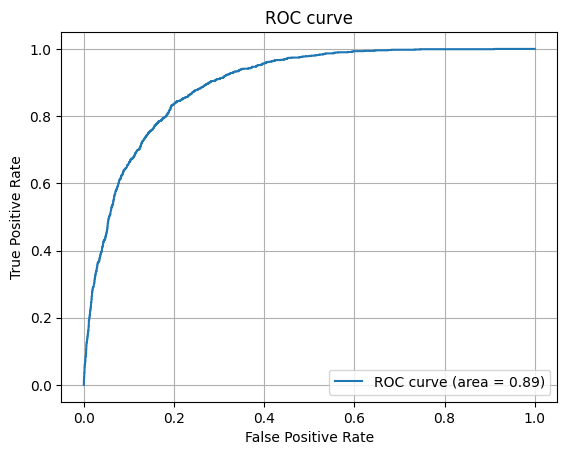

accuracy 0.8554616277142384
precision 0.683684794672586


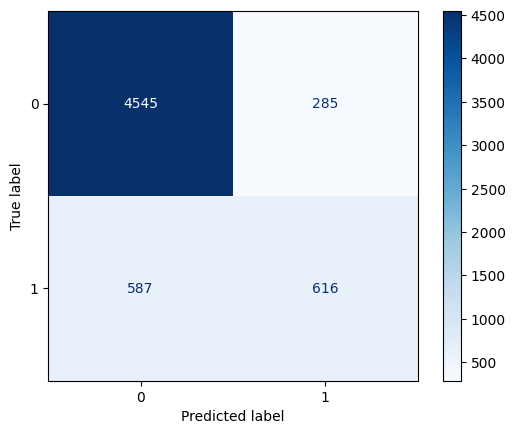

In [23]:
# AUCを計算
fpr, tpr, thresholds = roc_curve(np.asarray(y_test), y_pred)
print("AUC", auc(fpr, tpr))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc(fpr, tpr))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# accuracy, precisionを計算
acc = accuracy_score(np.asarray(y_test), np.round(y_pred))
precision = precision_score(np.asarray(y_test), np.round(y_pred))
print("accuracy", acc)
print("precision", precision)

# 混同行列をプロット
y_pred = np.round(y_pred)
cm = confusion_matrix(np.asarray(y_test), np.where(y_pred < 0.5, 0, 1))
cmp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmp.plot(cmap=plt.cm.Blues)
plt.show()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

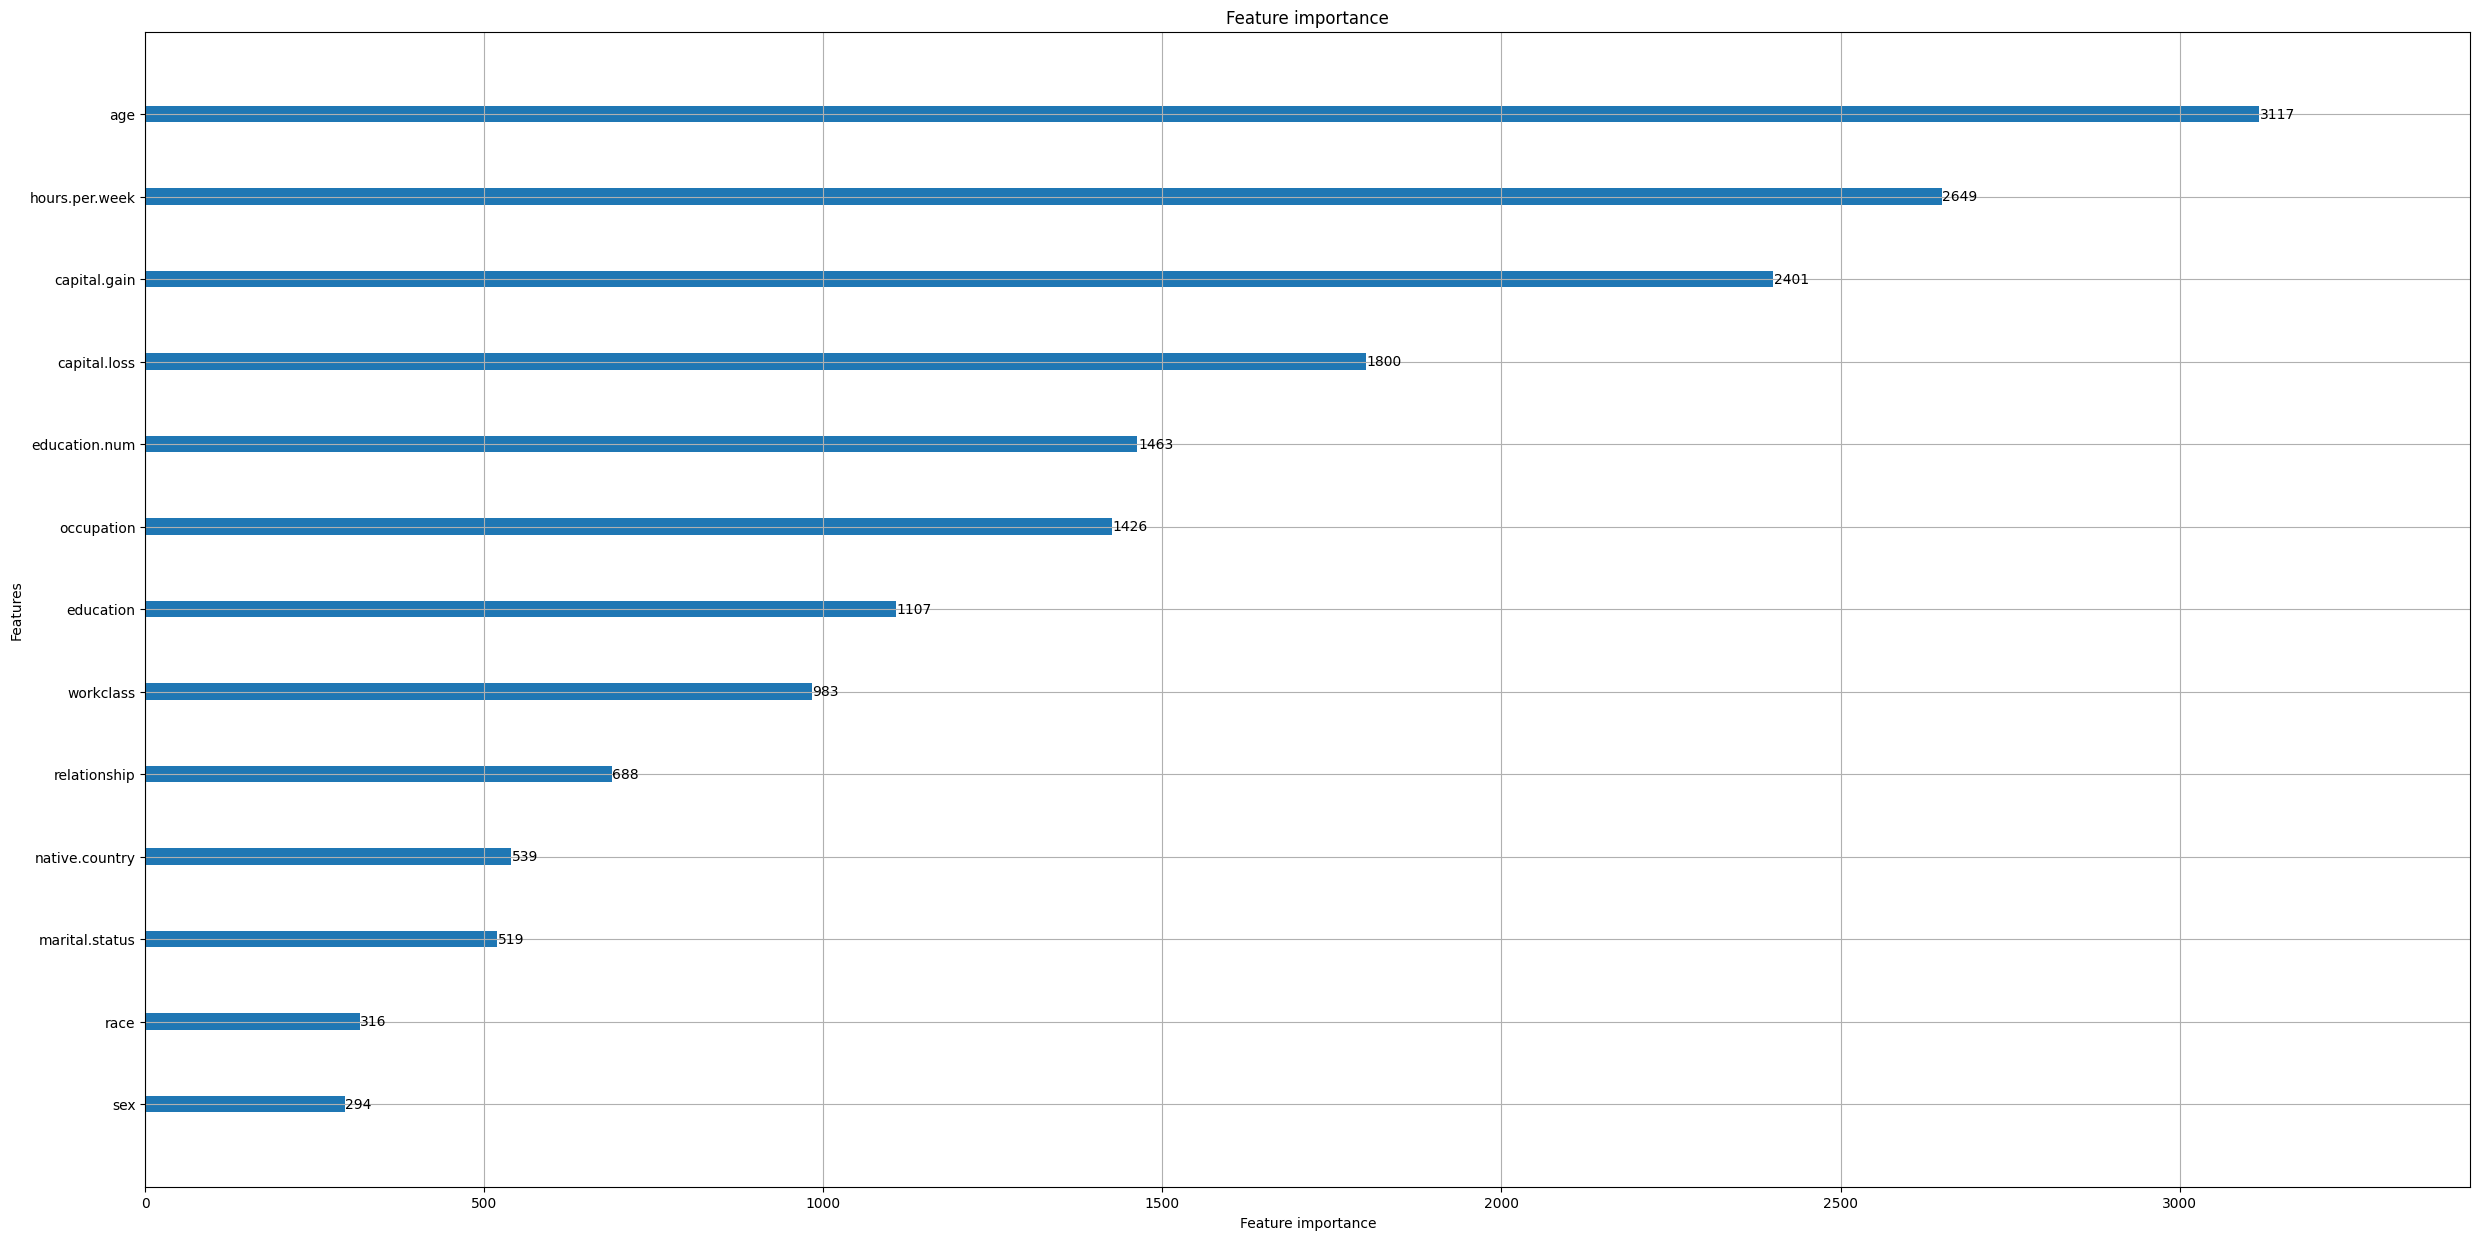

In [24]:
# 重要度としては「特徴量が分岐（ノード）の条件式で使用された回数」（＝デフォルト）
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='split')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

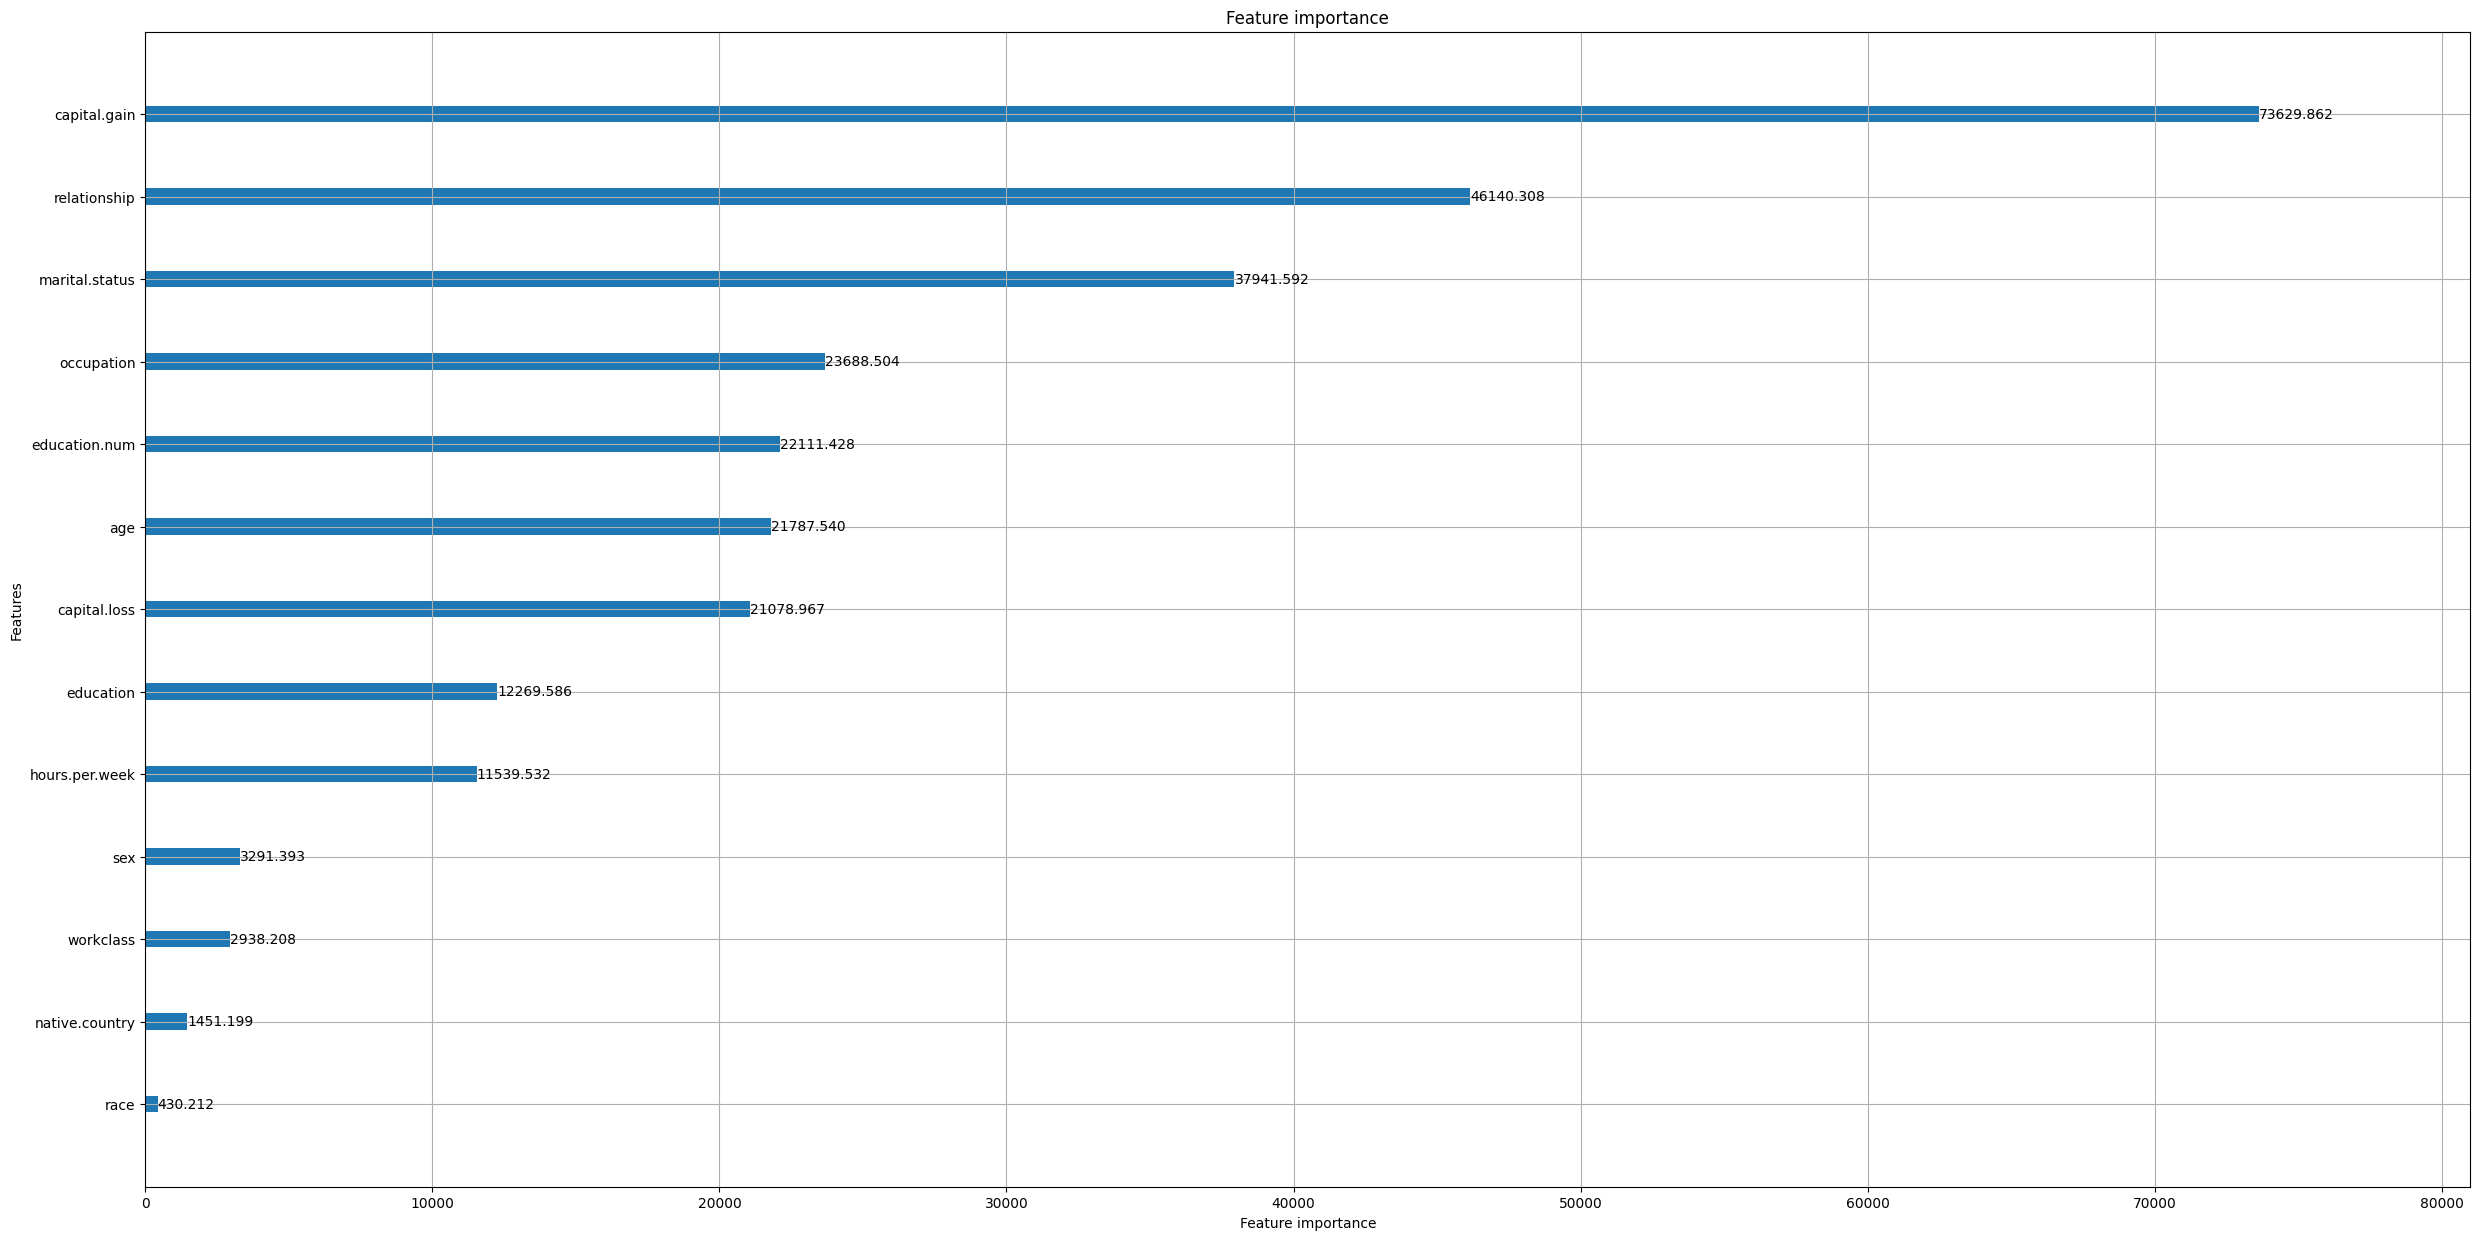

In [25]:
# 重要度としては「特徴量がある分岐（ノード）において目的関数の改善に寄与した度合い」
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='gain')

In [26]:
# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [27]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [28]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(df.drop('income',axis=1).columns) # 特徴量名のリスト(目的変数target以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
9,capital.gain,0.264572
6,relationship,0.165794
4,marital.status,0.136334
5,occupation,0.085119
3,education.num,0.079452


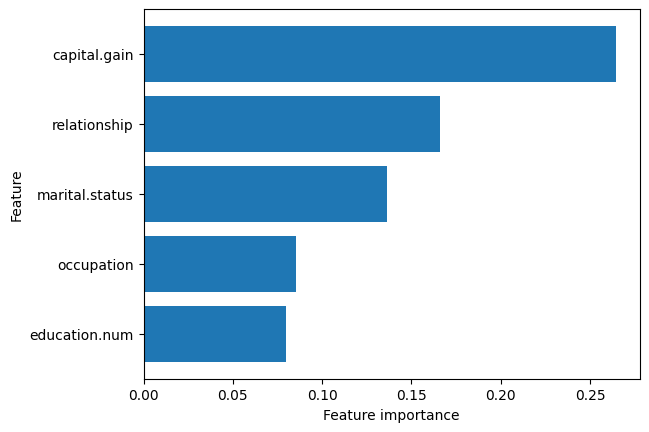

In [29]:
# 特徴量重要度の可視化
n_display = 5 # 上位10個に制限
plot_feature_importance(df_importance.iloc[:n_display,:])

In [30]:
import csv
# 決定木をDataFrameに変換
model.trees_to_dataframe().to_csv('adult_uci_label-categoricalfeature-optuna-再現_decisiontree.csv', index=False, header=True, encoding='UTF-8', sep=',', quoting=csv.QUOTE_ALL)

In [31]:
df_tree = pd.read_csv('adult_uci_label-categoricalfeature-optuna-再現_decisiontree.csv')

In [32]:
df_tree.head(10)

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S1,0-S7,NaN,capital.gain,3364.250000,5036.500000000001,<=,left,None,-0.961185,0.000000,18205
1,0,2,0-S1,0-S3,0-S2,0-S0,education.num,1270.829956,12.500000000000002,<=,left,None,-0.966836,3362.060000,16801
2,0,3,0-S3,0-S6,0-S4,0-S1,capital.loss,388.454010,1789.0000000000002,<=,left,None,-0.973820,2548.210000,12734
3,0,4,0-S6,0-L0,0-S9,0-S3,education.num,74.631798,8.500000000000002,<=,left,None,-0.975374,2456.160000,12274
4,0,5,0-L0,NaN,NaN,0-S6,NaN,NaN,NaN,NaN,NaN,NaN,-0.983689,408.025786,2039
5,0,5,0-S9,0-S13,0-S10,0-S6,capital.gain,25.855200,4243.500000000001,<=,left,None,-0.973640,2048.130000,10235
6,0,6,0-S13,0-S14,0-L14,0-S9,race,14.453300,1||4,==,right,NaN,-0.973928,2019.320000,10091
7,0,7,0-S14,0-S22,0-S26,0-S13,education.num,15.896000,10.500000000000002,<=,left,None,-0.972766,1772.180000,8856
8,0,8,0-S22,0-L7,0-L23,0-S14,native.country,2.527460,1||4||21||23||30||34,==,right,NaN,-0.973612,1563.470000,7813
9,0,9,0-L7,NaN,NaN,0-S22,NaN,NaN,NaN,NaN,NaN,NaN,-0.961185,23.212845,116


In [33]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35334 entries, 0 to 35333
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tree_index         35334 non-null  int64  
 1   node_depth         35334 non-null  int64  
 2   node_index         35334 non-null  object 
 3   left_child         17302 non-null  object 
 4   right_child        17302 non-null  object 
 5   parent_index       34604 non-null  object 
 6   split_feature      17302 non-null  object 
 7   split_gain         17302 non-null  float64
 8   threshold          17302 non-null  object 
 9   decision_type      17302 non-null  object 
 10  missing_direction  17302 non-null  object 
 11  missing_type       12412 non-null  object 
 12  value              35334 non-null  float64
 13  weight             35334 non-null  float64
 14  count              35334 non-null  int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 4.0+ MB
